# Introduction  

School dropout and educational failure pose significant challenges to economic growth and societal well-being, directly impacting students, families, institutions, and the broader community. According to the [Education Data Initiative](https://educationdata.org/college-dropout-rates#:~:text=Report%20Highlights.,Enrollment%20Statistics%20%7C%20Financial%20Aid%20Statistics), around 40% of undergraduate students in the United States drop out before completing their degrees. College dropouts face more financial challenges, earning an average of 35% less income and experiencing a 20% higher unemployment rate compared to their peers who graduate.  

In this project, We aim to build a classification model to predict student dropout and identify which students need more support to prevent them from dropping out. We will address the following questions:  

* What are the factors which contribute to student dropout, and how do they impact it?  
* Which students are most in need of support to stay in school?   

**Data**

The dataset contains 4,424 records with 35 attributes, where each record represents an individual student. It includes information available at the time of student enrollment, along with demographic, socioeconomic, and macroeconomic data, as well as the students’ academic performance at the end of the first and second semesters.

In [75]:
# Import important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing and EDA
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

In [76]:
# Load data

file_id = "18iiWxXMNV3tBgjpTshq3kOqiH1CLnD4U"
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file directly from the URL
students = pd.read_csv(download_url)

# Check the data
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

#Data Cleaning

This dataset is nearly clean thanks to the rigorous data preprocessing performed by the contributors of the [data](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention).

However, a few minor cleaning steps are still needed. First, I'll modify some column names to make them more consistent and easier to work with later and check if there are any missing values

In [77]:
students.isnull().sum()

,0
Marital status,0
Application mode,0
Application order,0
Course,0
Daytime/evening attendance,0
Previous qualification,0
Nacionality,0
Mother's qualification,0
Father's qualification,0
Mother's occupation,0


In [78]:
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [79]:
# Correct a column name that has a typo and replace single quotes with underscores
students.rename(columns = {"Nacionality": "Nationality",
                           "Mother's qualification": "Mother_qualification",
                           "Father's qualification": "Father_qualification",
                           "Mother's occupation": "Mother_occupation",
                           "Father's occupation": "Father_occupation",
                           "Age at enrollment": "Age"}, inplace = True)

# Replace white space in the column names with underscore
students.columns = students.columns.str.replace(' ', '_')

# Remove the parenthesis
students.columns = students.columns.str.replace('(', '')
students.columns = students.columns.str.replace(')', '')

I'll change the data types of columns that should be categorical from ‘int’ to ‘category’ to ensure that classification models treat these columns as categorical data rather than numerical.

In [80]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Application_order', 'Course',
      'Daytime/evening_attendance', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International', 'Target']

students[col] = students[col].astype('category')

In [81]:
students.head(10)

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Nationality,Mother_qualification,Father_qualification,Mother_occupation,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
5,2,12,1,17,0,12,1,22,27,10,...,0,5,17,5,11.500000,5,16.2,0.3,-0.92,Graduate
6,1,1,1,12,1,1,1,13,28,8,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
7,1,9,4,11,1,1,1,22,27,10,...,0,5,5,0,0.000000,0,15.5,2.8,-4.06,Dropout
8,1,1,3,10,1,1,15,1,1,10,...,0,6,7,6,14.142857,0,16.2,0.3,-0.92,Graduate
9,1,1,1,10,1,1,1,1,14,5,...,0,6,14,2,13.500000,0,8.9,1.4,3.51,Dropout


In [82]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   category
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   category
 5   Previous_qualification                        4424 non-null   category
 6   Nationality                                   4424 non-null   category
 7   Mother_qualification                          4424 non-null   category
 8   Father_qualification                          4424 non-null   category
 9   Mother_occupation                             4424 n

#Exploratory Data Analysis

There are 34 features in this dataset. I will examine their relationship with the target variable, which is a three-class categorical data. The features that have no association with the label will be the potential variables to be removed from modeling.



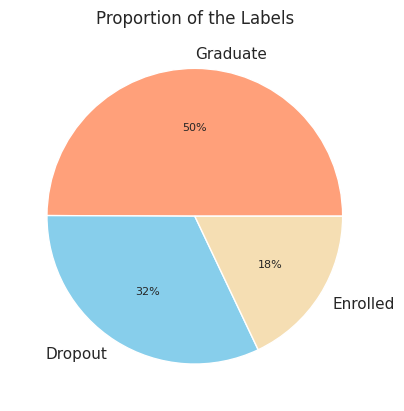

In [83]:
# Check the proportion of the labels(dropout, enrolled, and graduate) in the target variable
labels = students['Target'].value_counts().index
values = students['Target'].value_counts().values

plt.pie(values, labels = labels, colors = ['lightsalmon', 'skyblue', 'wheat'],
        autopct = '%1.0f%%')
plt.title('Proportion of the Labels');

From the pie chart above we can see that the data is imbalanced: with about 50% of the labels are 'Graduate', 32% are 'Dropout', and 18% are 'Enrolled'.

The labels are string, I will encode them as ordinal data -- 0 represents 'Dropout', 1 represents 'Enrolled', and 2 represents 'Graduate' -- since most classification models only handle numeric values.

In [84]:
# Encode the labels as ordinal data (0 - 'Dropout', 1 - 'Enrolled', and 2 - 'Graduate')
students['Target_encoded'] = OrdinalEncoder(categories = [['Dropout', 'Enrolled', 'Graduate']]).fit_transform(students[['Target']])

# Drop 'Target' variable
students.drop('Target', axis = 1, inplace = True)

In [85]:
students['Target_encoded'].value_counts(normalize=True)*100

,proportion
Target_encoded,
2.0,49.932188
0.0,32.120253
1.0,17.947559


The encoded labels are matching with the proportion pie chart above. We are good to go ahead.

##Categorical Feature Analysis


###Univariate Analysis - Let's understand the distribution of each categories through count plots

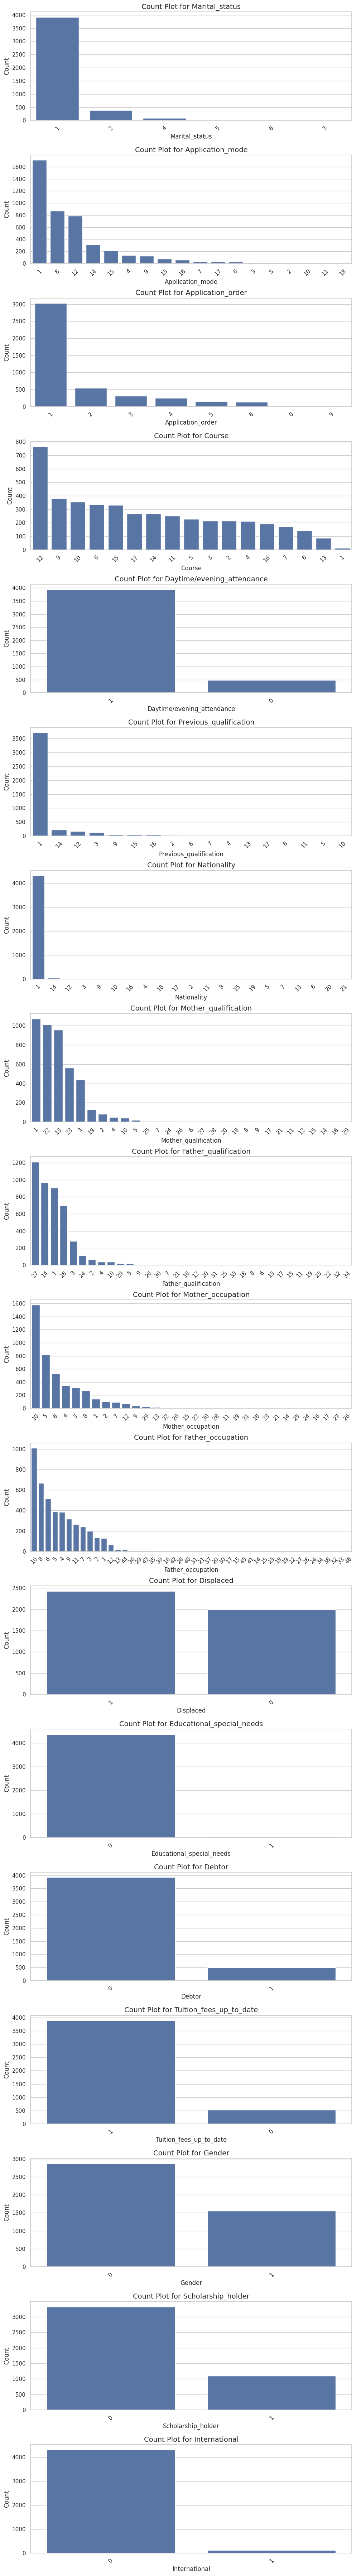

In [86]:
# Univariate Analysis
# Select categorical features
categorical_features = students.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Set figure size depending on number of plots
plt.figure(figsize=(10, len(categorical_features) * 4))

# Loop through categorical features and plot them vertically
for i, col in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(data=students, x=col, order=students[col].value_counts().index)
    plt.title(f'Count Plot for {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


1) Marital Status is heavily skewed toward one group, which may reduce its impact unless the minority classes have distinct dropout patterns.

2) Application Mode and Order show clear preference for a few categories. These could signal motivation or institutional processes and might be useful predictors.

3) Course shows a broad distribution, which is promising—it could help the model differentiate dropout risk across programs.

4) Daytime/Evening Attendance is mostly daytime, but evening students might represent a unique group (e.g., working students), possibly influencing outcomes.

5) Previous Qualification and Nationality have low variability, especially nationality, which may limit their predictive power.

6) Parental Education and Occupation have high cardinality and long tails. They might capture socioeconomic factors if grouped smartly.

7) Displaced, Special Needs, Debtor, and Tuition Fees are binary and imbalanced, but they likely capture key risk factors—especially financial-related ones.

8) Gender, Scholarship Holder, and International Status are slightly imbalanced. Their usefulness will depend on how they interact with other features.

9) Overall, I’ll revisit these after initial model runs to evaluate their importance and decide if any features need transformation, grouping, or exclusion.

###Bivariate Analysis - Chi-Square Independence Test for Categorical Variables

The Chi-Square independence test will be implemented to check the association between the categorical variables and the dependent variable, with the hypothesis as follows:  

$H_{0}$: the two variables are independent  
$H_{1}$: the two variables are dependent  

$\alpha$ = 0.05

I will reject the null hypothesis and accept the alternative hypothesis if the p-value is less than 0.05, meaning the two variables are dependent. If the p-value is greater than or equal to 0.05, I fail to reject the null hypothesis, meaning the two variables are independent.

In [87]:
# list of categorical features
cats = ['Marital_status', 'Application_mode', 'Application_order',
        'Course','Daytime/evening_attendance', 'Previous_qualification',
        'Nationality','Mother_qualification', 'Father_qualification',
        'Mother_occupation', 'Father_occupation', 'Displaced',
        'Educational_special_needs', 'Debtor','Tuition_fees_up_to_date',
        'Gender', 'Scholarship_holder','International']

# Get the p-values from Chi-Square indenpendence tests
p_value = []

for col in cats:
    crosstable = pd.crosstab(index = students[col],
                             columns = students['Target_encoded'])
    p = chi2_contingency(crosstable)[1]
    p_value.append(p)

chi2_result = pd.DataFrame({
    'Variable': cats,
    'P_value': [round(ele, 5) for ele in p_value]
})

chi2_result = chi2_result.sort_values('P_value')

chi2_result

,Variable,P_value
0,Marital_status,0.00000
1,Application_mode,0.00000
2,Application_order,0.00000
3,Course,0.00000
4,Daytime/evening_attendance,0.00000
5,Previous_qualification,0.00000
7,Mother_qualification,0.00000
8,Father_qualification,0.00000
13,Debtor,0.00000
9,Mother_occupation,0.00000


Most of the p-values are close to zero, except for three variables ('Nationality', 'International', 'Educational_special_needs') with very high p-values (0.24, 0.53, 0.73), indicating that no statistically significant association between these three features and the label. I will exclude them from modeling.

**We used the Chi-Square test to evaluate the dependence of categorical features on the target variable. Since this test is only applicable to categorical variables, we now proceed to explore the numerical features using appropriate techniques.**

In [88]:
stud_selected = students.drop(['Nationality', 'International', 'Educational_special_needs'],
                              axis = 1)

##Numerical Feature Analysis
###Estimates of Location and Variability

In [89]:
students.describe()

,Age,Curricular_units_1st_sem_credited,Curricular_units_1st_sem_enrolled,Curricular_units_1st_sem_evaluations,Curricular_units_1st_sem_approved,Curricular_units_1st_sem_grade,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target_encoded
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,23.265145,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,1.178119
std,7.587816,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.888243
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,1.000000
75%,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,2.000000
max,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,2.000000


Looking at Age, Curricular_units_1st_sem_credited and Curricular_units_1st_sem_enrolled, its evident that there are outliers in the data.

Age - 75% quartile is up-to 25 and max is 70 years of age, which is a huge jump.

Curricular_units_1st_sem_credited - 75% quartile is up-to 0 and max is at 20 credits, which is a huge jump. Similarly it is same with Curricular_units_1st_sem_enrolled.

###Univariate Analysis - Histograms to visualise the distribution of numerical feature

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


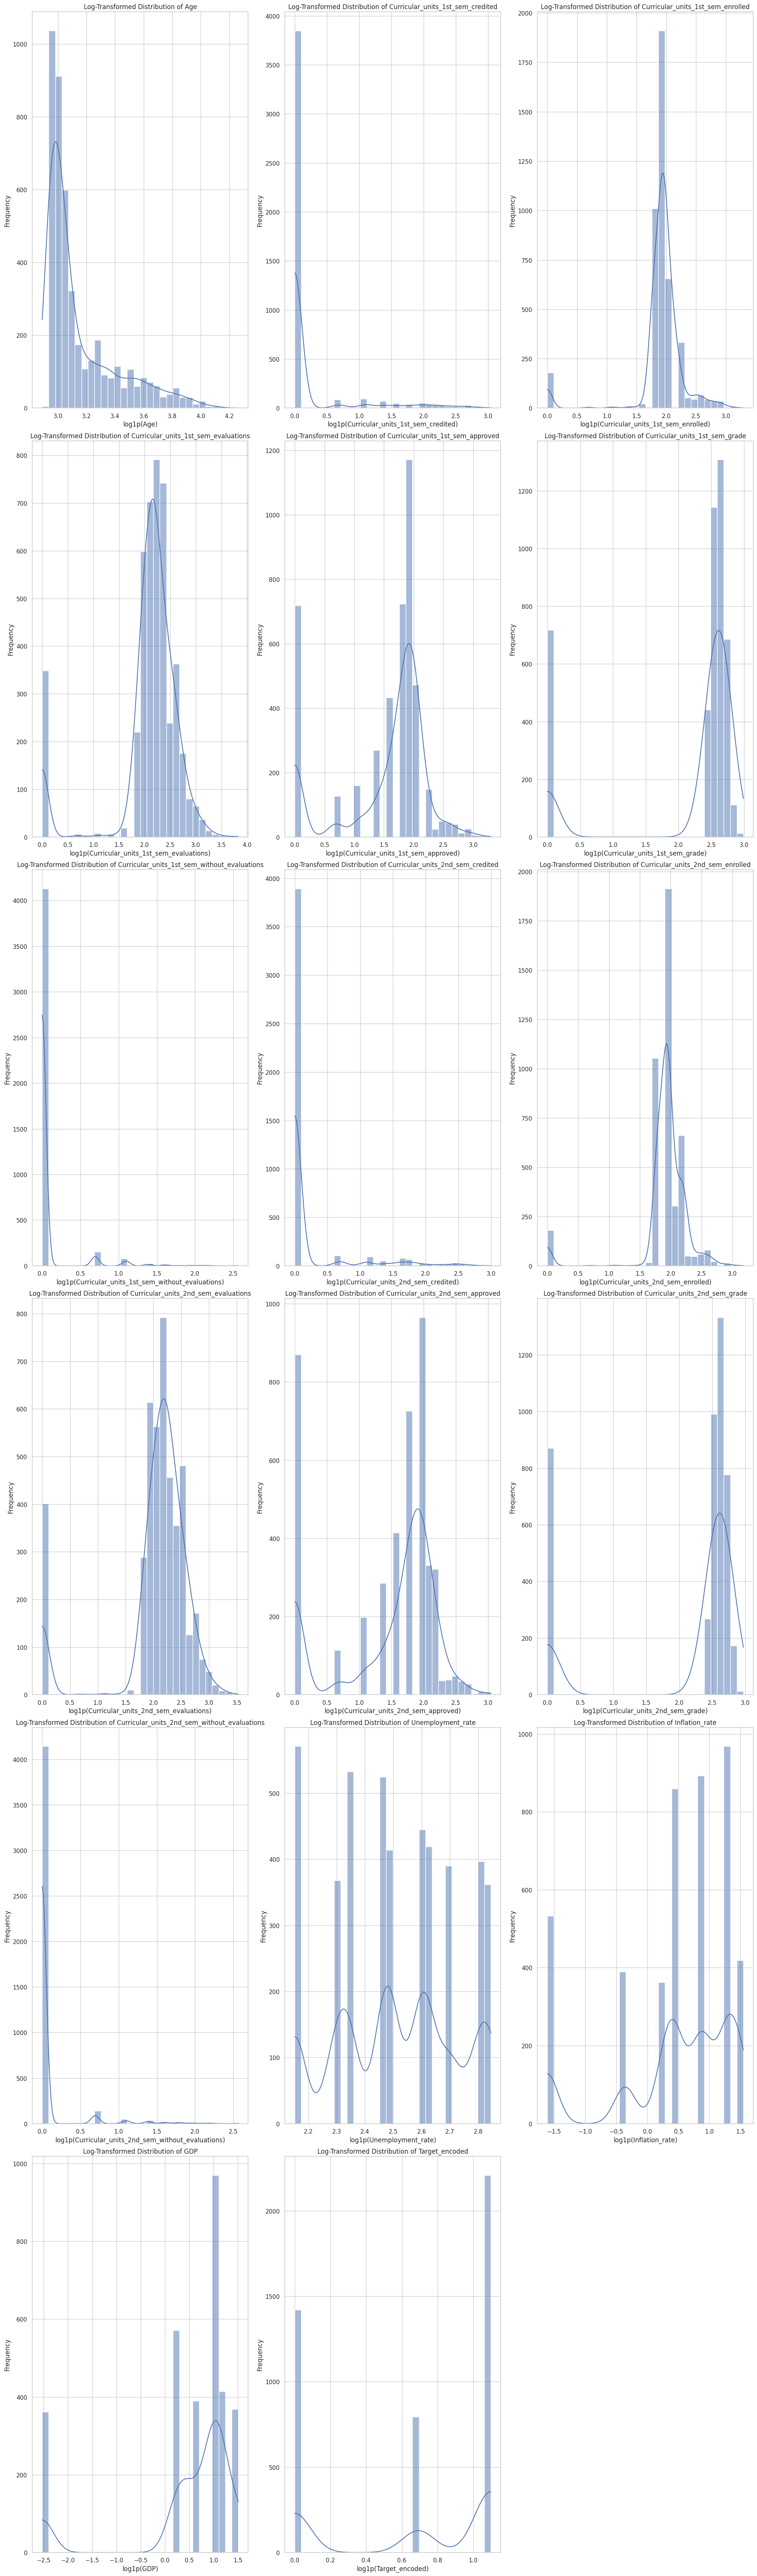

In [90]:
#Histogram - Univariate Analysis(log transformed)
numerical_cols = students.select_dtypes(include=['int64', 'float64']).columns

# Set up the plot
plt.figure(figsize=(20, len(numerical_cols) * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, i)

    # Apply log transformation safely
    log_data = np.log1p(students[col])  # log1p = log(1 + x), safe for zero values

    sns.histplot(log_data, kde=True, bins=30)
    plt.title(f'Log-Transformed Distribution of {col}')
    plt.xlabel(f'log1p({col})')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Looking at these log-transformed histograms, I can tell that a lot of the data was originally skewed — probably with long tails or a lot of zeros. After applying the log transformation, the shapes of the distributions look a lot more normalized or at least smoothed out.

1) Age: has a right skew originally, but the log transformation helped compress the extreme values. Now, I can clearly see that most students fall into a narrow age band.

2) Curricular Units (1st & 2nd Sem): For things like curricular_units_1st_sem_approved, grade, evaluations, and similar for the 2nd semester, I see clear peaks and groupings. The log scale helped reveal subtleties, like small groups with low or zero completions or grades. Some of the variables still have sharp peaks — maybe a lot of students scored zeros or maxed out the units.

3) Unemployment Rate & Inflation: These were categorical or rounded values originally, so even after log-transforming, they still look like bar charts. They seem to cluster around specific national benchmarks, which might reflect broader economic conditions.

In [91]:
# Make a copy of your original dataframe (For logistics regression model if necessary)
log_transformed_students = students.copy()
numerical_cols = students.select_dtypes(include=['int64', 'float64']).columns

# Track saved log-transformed columns
log_transformed_cols = []

for col in numerical_cols:
    min_val = students[col].min()

    if min_val < 0:
        shift = abs(min_val) + 1
        log_transformed_students[col + '_log'] = np.log1p(students[col] + shift)
        print(f"Shifted and log-transformed '{col}' by +{shift}")
    else:
        log_transformed_students[col + '_log'] = np.log1p(students[col])
        print(f"Log-transformed '{col}' without shift")

    log_transformed_cols.append(col + '_log')

# ✅ Display all saved log-transformed columns
print("\nAll log-transformed columns:")
for col in log_transformed_cols:
    print(col)


Log-transformed 'Age' without shift
Log-transformed 'Curricular_units_1st_sem_credited' without shift
Log-transformed 'Curricular_units_1st_sem_enrolled' without shift
Log-transformed 'Curricular_units_1st_sem_evaluations' without shift
Log-transformed 'Curricular_units_1st_sem_approved' without shift
Log-transformed 'Curricular_units_1st_sem_grade' without shift
Log-transformed 'Curricular_units_1st_sem_without_evaluations' without shift
Log-transformed 'Curricular_units_2nd_sem_credited' without shift
Log-transformed 'Curricular_units_2nd_sem_enrolled' without shift
Log-transformed 'Curricular_units_2nd_sem_evaluations' without shift
Log-transformed 'Curricular_units_2nd_sem_approved' without shift
Log-transformed 'Curricular_units_2nd_sem_grade' without shift
Log-transformed 'Curricular_units_2nd_sem_without_evaluations' without shift
Log-transformed 'Unemployment_rate' without shift
Shifted and log-transformed 'Inflation_rate' by +1.8
Shifted and log-transformed 'GDP' by +5.06
Log-

###Bivariate Analysis - Spearman's rank correlation between numerical features and the Target

A heatmap is used to visualize the Spearman's rank correlation between numerical features and the labels. Spearman's rank correlation measures the strength and direction of monotonic association between two variables. It can capture both linear and nonlinear monotonic relationships.

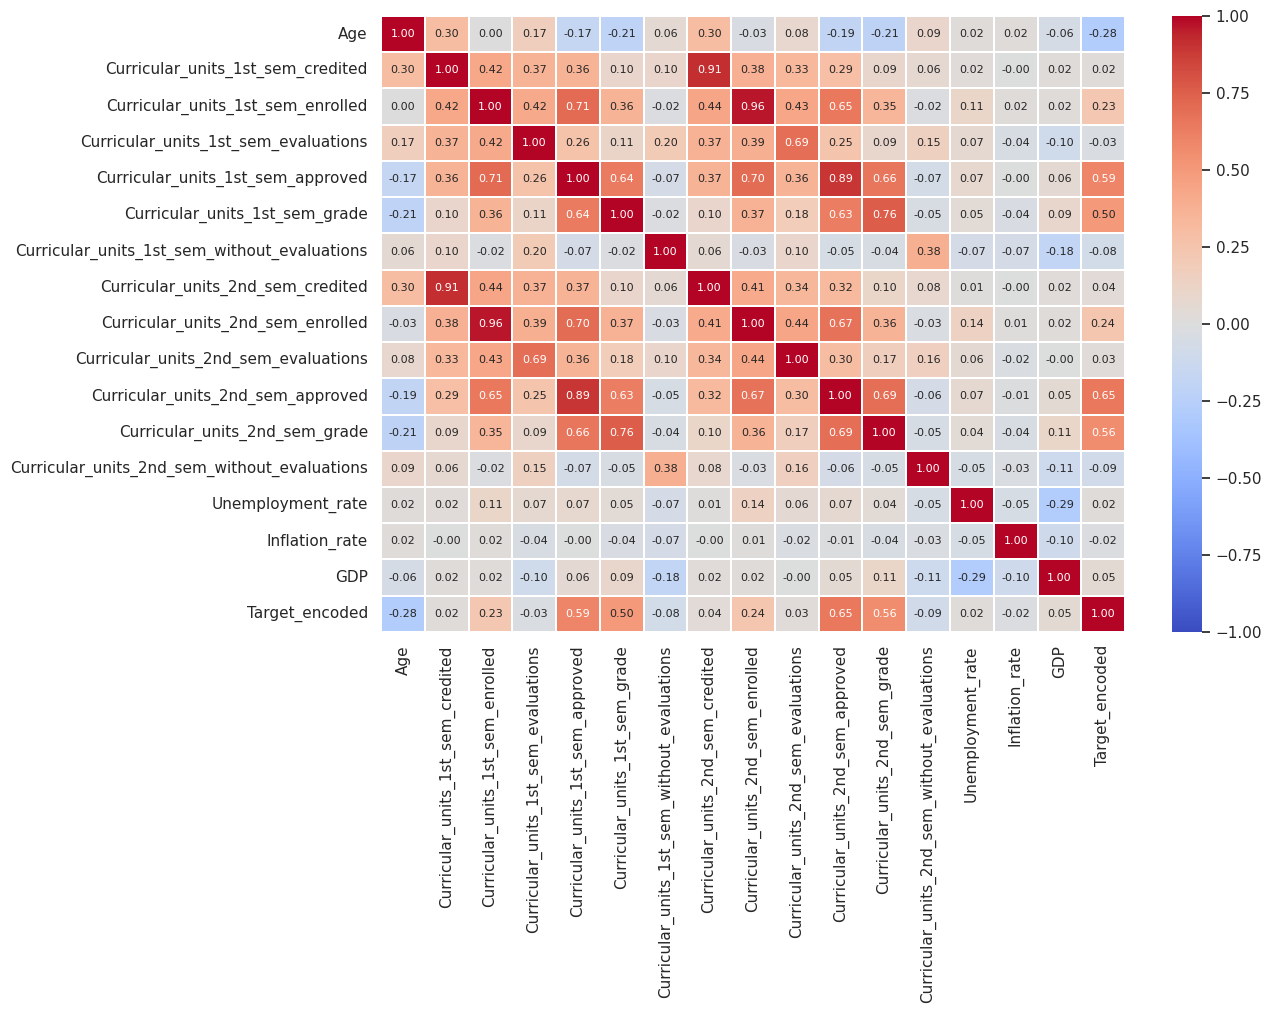

In [92]:
# Numeric features
num_features = students[['Age',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved',
       'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved',
       'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations',
       'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target_encoded']]

# Heatmap of correlation matrix
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 8})
hm = sns.heatmap(num_features.corr(method = 'spearman'),
                 cmap = 'coolwarm', annot = True, fmt = '.2f',
                 linewidths = .2, vmin = -1, vmax = 1, center = 0)

As can be seen from the heat map, there are four features ('Curricular_units_2nd_sem_approved’, 'Curricular_units_2nd_sem_grade’, ’Curricular_units_1st_sem_approved’, 'Curricular_units_1st_sem_grade’) that have relatively high and positive correlations with the label, while some have very low correlations(e.g., 'Unemployment_rate', 'Inflation_rate')

The heat map also reveals multicollinearity among the features related to curricular units. These features represent students' academic performance at the end of the first and second semesters. I will aggregate them to get the average value between the two semesters.

In [93]:
# Averaging academic performance data across two semesters
stud_selected['avg_credited'] = stud_selected[['Curricular_units_1st_sem_credited',
                                'Curricular_units_2nd_sem_credited']].mean(axis = 1)
stud_selected['avg_enrolled'] = stud_selected[['Curricular_units_1st_sem_enrolled',
                                'Curricular_units_2nd_sem_enrolled']].mean(axis = 1)
stud_selected['avg_evaluations'] = stud_selected[['Curricular_units_1st_sem_evaluations',
                                   'Curricular_units_2nd_sem_evaluations']].mean(axis = 1)
stud_selected['avg_approved'] = stud_selected[['Curricular_units_1st_sem_approved',
                                'Curricular_units_2nd_sem_approved']].mean(axis = 1)
stud_selected['avg_grade'] = stud_selected[['Curricular_units_1st_sem_grade',
                             'Curricular_units_2nd_sem_grade']].mean(axis = 1)
stud_selected['avg_without_evaluations'] = stud_selected[['Curricular_units_1st_sem_without_evaluations',
                                           'Curricular_units_2nd_sem_without_evaluations']].mean(axis = 1)

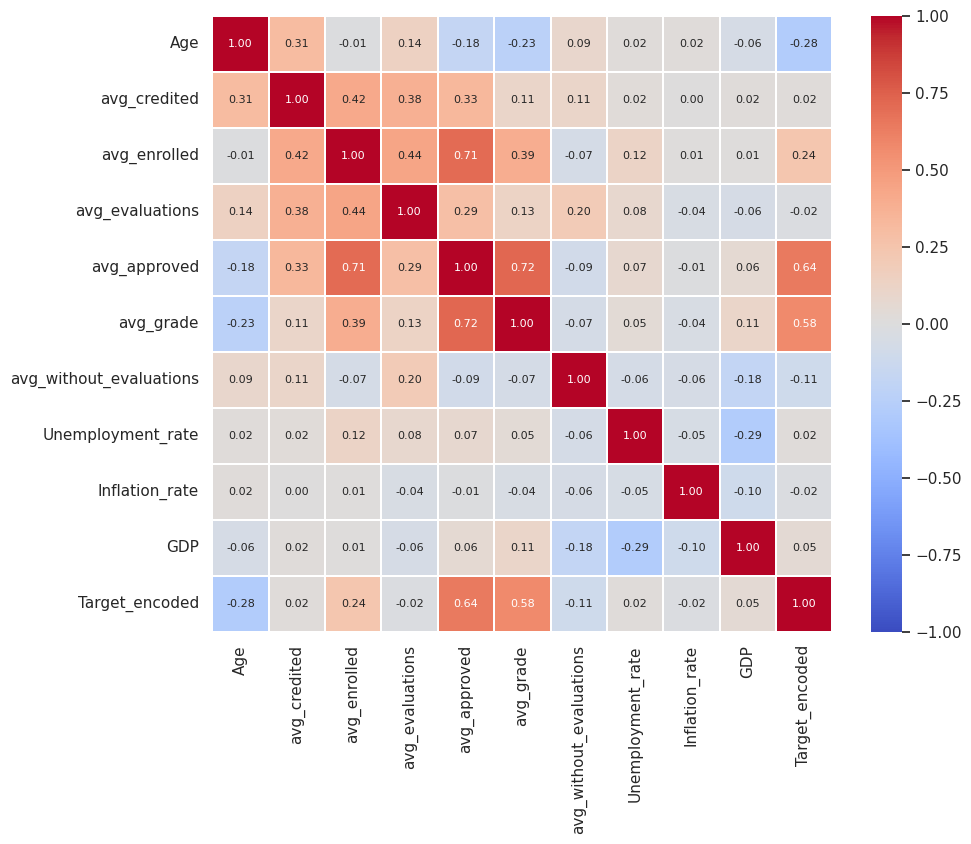

In [94]:
# plot the heat map of correlation matrix again
num_features = stud_selected[['Age', 'avg_credited', 'avg_enrolled',
                              'avg_evaluations', 'avg_approved',
                              'avg_grade', 'avg_without_evaluations',
                              'Unemployment_rate', 'Inflation_rate',
                              'GDP', 'Target_encoded']]

plt.figure(figsize = (10, 8))
plt.rcParams.update({'font.size': 8})
sns.heatmap(num_features.corr(method = 'spearman'), vmin = -1, vmax = 1, center = 0,
            cmap = 'coolwarm', fmt = '.2f', linewidths = .2, annot = True);

The new correlation matrix above shows that 'curri_avg_approved' and 'curri_avg_grade' still have a relatively high correlation with the labels ('Target_encoded'), while 'curri_avg_credited' and 'curri_avg_evaluations', along with 'the macroeconomic data ('Unemployment_rate', 'Inflation_rate'), have very low correlations, all between -0.02 and 0.02. I will exclude these four features.

The multicollinearity still exists among the academic data. I'll take it into account when selecting the models.

Let's check how 'curri_avg_approved' and 'curri_avg_grade' are associated with students' situation at the end of the normal duration of the course.

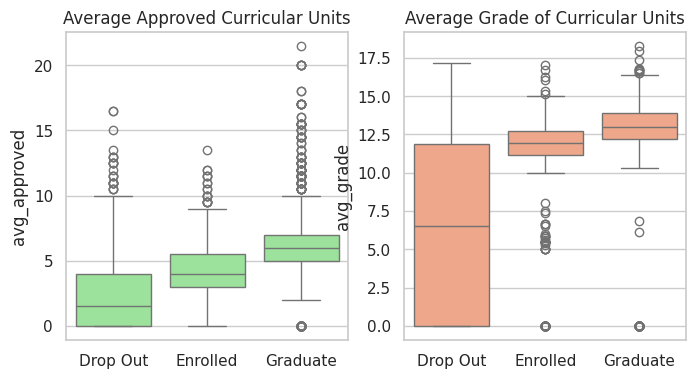

In [95]:
# Plot 'avg_approved' and 'avg_grade' vs. Target
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'avg_approved',
            color = 'lightgreen', ax = ax1)
ax1.set_title('Average Approved Curricular Units')
ax1.set_xlabel("")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate']);

sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'avg_grade',
            color = 'lightsalmon', ax = ax2)
ax2.set_title('Average Grade of Curricular Units')
ax2.set_xlabel("")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate']);

It's not surprising that 'Graduate' is associated with more approved curricular units and higher grades. However, there are some instances of a 0 value for average grade and average approved curricular units in the 'Graduate' class.

In [96]:
# Check the rows with zero average approved curricular units and students being graduade
stud_selected.loc[(stud_selected['avg_approved'] == 0) & (stud_selected['Target_encoded'] == 2)]

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Unemployment_rate,Inflation_rate,GDP,Target_encoded,avg_credited,avg_enrolled,avg_evaluations,avg_approved,avg_grade,avg_without_evaluations
20,1,1,3,2,1,1,1,1,10,9,...,11.1,0.6,2.02,2.0,0.0,0.0,0.0,0.0,0.0,0.0
66,1,1,3,2,1,1,13,14,6,4,...,10.8,1.4,1.74,2.0,0.0,0.0,0.0,0.0,0.0,0.0
101,1,1,4,2,1,1,1,1,10,11,...,16.2,0.3,-0.92,2.0,0.0,0.0,0.0,0.0,0.0,0.0
405,1,1,1,2,1,1,1,14,4,10,...,12.7,3.7,-1.70,2.0,0.0,0.0,0.0,0.0,0.0,0.0
527,1,12,1,2,1,1,3,1,3,11,...,9.4,-0.8,-3.12,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,1,8,2,2,1,1,3,1,3,7,...,15.5,2.8,-4.06,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4291,1,1,1,2,1,1,1,28,5,6,...,15.5,2.8,-4.06,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4353,1,1,1,2,1,1,3,1,5,5,...,12.4,0.5,1.79,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4365,1,1,2,2,1,1,23,28,5,10,...,7.6,2.6,0.32,2.0,0.0,0.0,0.0,0.0,0.0,0.0


There are 75 data points where all data related to curricular units is zero, yet the students are labeled as 'Graduate.' This contradicts common sense, I will treat these rows as outliers and remove them from the dataset.

In [97]:
# Remove the outliers
stud_selected = stud_selected.drop(stud_selected.loc[(stud_selected['avg_approved'] == 0) & (stud_selected['Target_encoded'] == 2)].index)

# Check the rows with zero average grade and students being graduade
stud_selected.loc[(stud_selected['avg_grade'] == 0) & (stud_selected['Target_encoded'] == 2)]

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Unemployment_rate,Inflation_rate,GDP,Target_encoded,avg_credited,avg_enrolled,avg_evaluations,avg_approved,avg_grade,avg_without_evaluations


There is 0 rows with 0 average grade and students being graduade, meaning the 0 value for average grade and average approved curricular units in the 'Graduate' class correspond to the same data points.

In [98]:
# Drop unselected features along with the features that have been aggregated into new ones
stud_selected = stud_selected.drop(columns = ['Unemployment_rate', 'Inflation_rate',
                                              'avg_credited', 'avg_evaluations',
                                              'Curricular_units_1st_sem_credited',
                                              'Curricular_units_1st_sem_enrolled',
                                              'Curricular_units_1st_sem_evaluations',
                                              'Curricular_units_1st_sem_approved',
                                              'Curricular_units_1st_sem_grade',
                                              'Curricular_units_1st_sem_without_evaluations',
                                              'Curricular_units_2nd_sem_credited',
                                              'Curricular_units_2nd_sem_enrolled',
                                              'Curricular_units_2nd_sem_evaluations',
                                              'Curricular_units_2nd_sem_approved',
                                              'Curricular_units_2nd_sem_grade',
                                              'Curricular_units_2nd_sem_without_evaluations'])